In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
# define standard model
model = nn.Sequential(
    nn.Linear(1, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
)

In [3]:
# define loss and optimizer for standard model
loss_fn = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [4]:
# generate data and split in train and validaiton
N = 9000
p = 0.2
train = 7000
# test set numerosity = 1000 for simplicity
X = np.random.uniform(low=0, high=10, size=N)
U = np.random.binomial(1, p, N)
Y = np.random.normal(np.sqrt(X) + U * (3 * np.sqrt(X) + 1), 1, N)
# train and validation split
X_train = torch.tensor(X[:train], dtype=torch.float32).reshape(-1, 1)
Y_train = torch.tensor(Y[:train], dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X[train:], dtype=torch.float32).reshape(-1, 1)
Y_test = torch.tensor(Y[train:], dtype=torch.float32).reshape(-1, 1)


In [5]:
# train standard model
n_epochs = 100
batch_size = 1750
LOSS = []
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        # select x batch
        Xbatch = X_train[i : i + batch_size]
        # forward step
        y_pred = model(Xbatch)
        # select y batch
        ybatch = Y_train[i : i + batch_size]
        # obtain loss
        loss = loss_fn(y_pred, ybatch)
        # compute gradient
        optimizer.zero_grad()
        # backward propagation
        loss.backward()
        optimizer.step()
        # append loss for visualization
        LOSS.append(loss)
        print(f"Finished epoch {epoch}, latest loss {loss}", end="\r", flush=True)


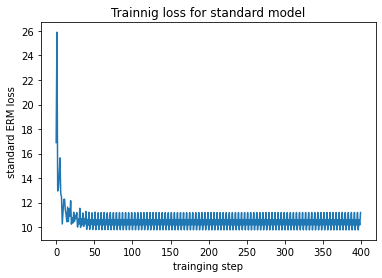

In [6]:
# plot loss
plt.plot([i for i in map(lambda x: (x.detach().numpy()), LOSS)])
# add label
plt.xlabel("trainging step")
plt.ylabel("standard ERM loss")
plt.title("Trainnig loss for standard model")
# display plot
plt.show()


In [7]:
# define custom RU loss
def RU_loss(z, a, gamma, y):
    L = (z - y) ** 2
    return torch.mean(
        (L / gamma)
        + (1 - (1 / gamma)) * a
        + (gamma - (1 / gamma)) * torch.nn.functional.relu(L - a)
    )


In [8]:
# train RU model
LOSS = {}
h_net = {}
a_net = {}
n_epochs = 100
gamma_values = [2, 6, 18]
for gamma in gamma_values:
    print(f"Training with  \u0393 = {gamma}" + " " * 100)  # unicode character for Gamma
    # initialize loss array
    LOSS[gamma] = []
    # initialize nets
    # define RU model h function net
    h_net[gamma] = nn.Sequential(
        nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 1)
    )
    # define RU model alpha function net
    a_net[gamma] = nn.Sequential(
        nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 1)
    )
    # define optimizer for RU model
    params = list(h_net[gamma].parameters()) + list(a_net[gamma].parameters())
    optimizer_ru = optim.Adam(params, lr=1e-2)
    for epoch in range(n_epochs):
        for i in range(0, len(X_train), batch_size):
            # select batch
            Xbatch = X_train[i : i + batch_size]
            # forward h net
            h = h_net[gamma](Xbatch)
            # forward alpha net
            a = a_net[gamma](Xbatch)
            # select y batch
            ybatch = Y_train[i : i + batch_size]
            # obtain RU loss
            ru_loss = RU_loss(h, a, gamma, ybatch)
            # backward propagation and training
            optimizer_ru.zero_grad()
            ru_loss.backward()
            optimizer_ru.step()
            # append loss for visualization
            LOSS[gamma].append(ru_loss)
            print(
                f"Finished epoch {epoch}, latest loss {ru_loss}", end="\r", flush=True
            )

Training with  Γ = 2                                                                                                    
Training with  Γ = 6                                                                                                    
Training with  Γ = 18                                                                                                    


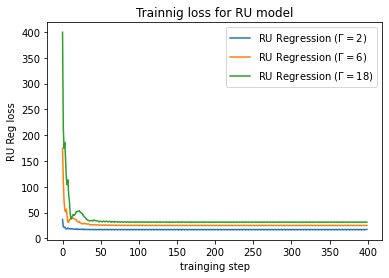

In [9]:
# loss for every epoch
for gamma in gamma_values:
    plt.plot(
        [i for i in map(lambda x: (x.detach().numpy()), LOSS[gamma])],
        label="RU Regression " + r"$(\Gamma=$" + f"{gamma})",
    )
# add plot labels
plt.xlabel("trainging step")
plt.ylabel("RU Reg loss")
plt.title("Trainnig loss for RU model")
# display legend
plt.legend()
# display plot
plt.show()


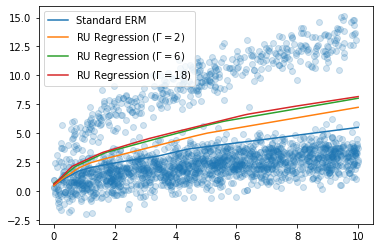

In [10]:
# plot both functions on test set
f, ax = plt.subplots(1)
# create euqally spaced points to display function
X_testing = torch.linspace(0.0, 10.0, 100).reshape(100, 1)
# add test set data
ax.scatter(X_test.numpy(), Y_test.numpy(), alpha=0.2)
# add standard ERM function
ax.plot(X_testing.numpy(), model(X_testing).detach().numpy(), label="Standard ERM")
# add RU functions with different levels of gamma
for gamma in gamma_values:
    ax.plot(
        X_testing.numpy(),
        h_net[gamma](X_testing).detach().numpy(),
        label="RU Regression " + r"$(\Gamma=$" + f"{gamma})",
    )
# display legend
ax.legend()
# display plot
plt.show()
